In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### 1. 读取数据， 分析各表字段信息

#### 1.1 附件1-会员信息表
* 可得知该店会员卡号，会员出生日期，性别，会员登记时间  
* 除了会员卡号，其余列均有缺值，可能为用户登记会员信息时少填。此处暂时不对缺值处理，因为知道卡号就能对应到会员。

In [2]:
member_info = pd.read_csv('附件1-会员信息表.csv')
display(member_info.head(2))
print(member_info.shape)
print(member_info.isna().sum())

,kh,csny,xb,djsj
0,c68b20b4,2002/11/2 0:00,0.0,2013/5/11 0:00
1,1ca15332,NaN,0.0,2004/11/4 16:31


(194761, 4)
kh          0
csny    34188
xb       9435
djsj    12684
dtype: int64


* 从出生日期/登记时间可提取出具体出生/登记年月信息

In [3]:
def parseOutDate(dt):
    if dt is np.nan:
        return dt           #如果日期是nan，则返回nan
    dt = dt.split(' ')[0]
    year = int(dt[0:4])
    if year > 2020:         #有一行年>2020，为异常值，设为nan
        return np.nan
    return datetime.strptime(dt, '%Y/%m/%d')
parseOutDate('2002/11/2 0:00') #函数测试

datetime.datetime(2002, 11, 2, 0, 0)

In [4]:
member_info['csny'] = member_info['csny'].apply(parseOutDate)
member_info['djsj'] = member_info['djsj'].apply(parseOutDate)

member_info['csny_year'] = member_info['csny'].dt.year
member_info['csny_month'] = member_info['csny'].dt.month
member_info['djsj_year'] = member_info['djsj'].dt.year
member_info['djsj_month'] = member_info['djsj'].dt.month

* 从会员出生年份生成一个分类变量 csny_year_cut。以便后期更好研究用户年龄。

In [5]:
csny_year_cut = []
for year in member_info['csny_year']:
    if year < 1940:
        csny_year_cut.append('outlier')
    elif year < 1950:
        csny_year_cut.append('1940-1950')
    elif year < 1960:
        csny_year_cut.append('1950-1960')
    elif year < 1970:
        csny_year_cut.append('1960-1970')        
    elif year < 1980:
        csny_year_cut.append('1970-1980')
    elif year < 1990:
        csny_year_cut.append('1980-1990')  
    elif year < 2000:
        csny_year_cut.append('1990-2000')  
    else:
        csny_year_cut.append('2000 after')  
member_info['csny_year_cut'] = csny_year_cut

In [6]:
display(member_info.head(2))
print(member_info.shape)

,kh,csny,xb,djsj,csny_year,csny_month,djsj_year,djsj_month,csny_year_cut
0,c68b20b4,2002-11-02,0.0,2013-05-11,2002.0,11.0,2013.0,5.0,2000 after
1,1ca15332,NaT,0.0,2004-11-04,NaN,NaN,2004.0,11.0,2000 after


(194761, 9)


#### 1.2 附件2-销售流水表
* 本表提供了该商店 16/17 年不同商品的销售流水。
* 可知不同商品以多少数量和价格在什么时间卖出去。
* 无缺值

In [7]:
total_sales = pd.read_csv('附件2-销售流水表.csv')
display(total_sales.head(2))
print(total_sales.shape)
print(total_sales.isna().sum())

,spbm,sj,sl,je,dtime
0,2811fe0b,180.0,1,180.0,2016/11/6 19:29
1,2811fe0b,1080.0,1,1080.0,2016/11/6 19:29


(1015366, 5)
spbm     0
sj       0
sl       0
je       0
dtime    0
dtype: int64


* 从消费时间可提取出具体年月季度信息

In [8]:
total_sales['dtime'] = total_sales['dtime'].apply(parseOutDate)

total_sales['dtime_year'] = total_sales['dtime'].dt.year
total_sales['dtime_quarter'] = total_sales['dtime'].dt.quarter
total_sales['dtime_month'] = total_sales['dtime'].dt.month

In [9]:
np.unique(total_sales['dtime_year'] )

array([2016, 2017])

In [10]:
display(total_sales.head(2))
print(total_sales.shape)

,spbm,sj,sl,je,dtime,dtime_year,dtime_quarter,dtime_month
0,2811fe0b,180.0,1,180.0,2016-11-06,2016,4,11
1,2811fe0b,1080.0,1,1080.0,2016-11-06,2016,4,11


(1015366, 8)


#### 1.3 附件3-会员消费明细表
* 可知会员在该店消费的时间，购买的商品编码与名称，商品价格，购买量与消费金额。
* 无缺值

In [11]:
member_sales = pd.read_csv('附件3-会员消费明细表.csv', encoding='gb18030')
display(member_sales.head(2))
print(member_sales.shape)
print(member_sales.isna().sum())

,kh,dtime,spbm,sl,sj,je,spmc
0,5bfd4a2e,2016/5/8 11:32,9096d06f,1,1250.0,1125.0,素然B价件
1,0a69471f,2016/5/8 13:40,9096d06f,1,1850.0,1665.0,素然B价件


(911702, 7)
kh       0
dtime    0
spbm     0
sl       0
sj       0
je       0
spmc     0
dtype: int64


* 销售数量为负值退货,消费金额为0是赠品。
由以下代码可知，有7038行退货； 2450行为赠品

In [12]:
buy_type = []
for sl, je in zip(member_sales['sl'],member_sales['je']):
    if (sl < 0) | (je < 0):
        buy_type.append('return')
    elif je == 0:
        buy_type.append('gift')
    else:
        buy_type.append('buy')
member_sales['buy_type'] = buy_type

In [13]:
Counter(buy_type)

Counter({'buy': 901997, 'gift': 2450, 'return': 7255})

* 从消费时间可提取出具体年月季度信息

In [14]:
member_sales['dtime'] = member_sales['dtime'].apply(parseOutDate)

member_sales['dtime_year'] = member_sales['dtime'].dt.year
member_sales['dtime_quarter'] = member_sales['dtime'].dt.quarter
member_sales['dtime_month'] = member_sales['dtime'].dt.month

In [15]:
display(member_sales.head(2))
print(member_sales.shape)

,kh,dtime,spbm,sl,sj,je,spmc,buy_type,dtime_year,dtime_quarter,dtime_month
0,5bfd4a2e,2016-05-08,9096d06f,1,1250.0,1125.0,素然B价件,buy,2016,2,5
1,0a69471f,2016-05-08,9096d06f,1,1850.0,1665.0,素然B价件,buy,2016,2,5


(911702, 11)


#### 1.4 附件4-商品信息表
* 可知商品编码所对应的商品本身的名称，品牌，类别，税与进价售价信息。
* 无缺值

In [16]:
commodity_info = pd.read_csv('附件4-商品信息表.csv', encoding='gb18030')
display(commodity_info.head(2))
print(commodity_info.shape)
print(commodity_info.isna().sum())

,spbm,spmc,ppbm,lbbm,jxs,xxs,wsjj,hsjj,sj
0,ce385235,珂罗蒂雅服装系列,90,70101,1.06,1.06,0.0,0.0,0.0
1,c34ffa55,赛琪系列商品B,376,30501,1.17,1.17,0.0,0.0,0.0


(24170, 9)
spbm    0
spmc    0
ppbm    0
lbbm    0
jxs     0
xxs     0
wsjj    0
hsjj    0
sj      0
dtype: int64


### 2. 统计该商场的总销售额，以及按年度，月度统计销售额。分析销售额的变化是否有周期性。
所用表：附件2-销售流水表
* 总销售额

In [17]:
sum(total_sales['je'])

1304112720.8599389

* 年度总销售额

In [18]:
total_sales.groupby(['dtime_year'])['je'].sum().to_frame()

,je
dtime_year,
2016,7.288018e+08
2017,5.753109e+08


* 月度总销售额

In [19]:
total_sales.groupby(['dtime_month'])['je'].sum().to_frame()

,je
dtime_month,
1,1.558281e+08
2,1.113648e+08
3,1.304841e+08
4,1.088102e+08
5,1.274940e+08
6,1.059620e+08
7,1.133875e+08
8,1.300149e+08
9,1.239257e+08


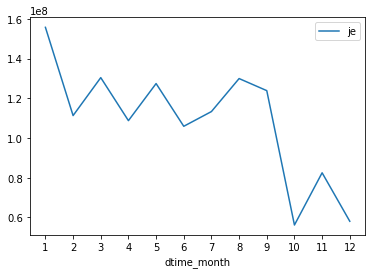

In [20]:
total_sales.groupby(['dtime_month'])['je'].sum().to_frame().plot()
plt.xticks(list(range(1,13,1)))
plt.show()

* 分析周期性：  
由月总销售额可见，该商店在每年最后一个季度及10/11/12月的销售额相对较少。   
在1月的总销售额最多。   
1-6月总销售额波动呈现一个月较多，后一个月较低的规律。

### 3. 该店有效会员的性别，年龄，及注册时间情况分析。
（请自行理解“有效会员”的描述，并给出说明。）  
所用表：附件1-会员信息表

#### 3.1 有效会员：   
* 发现会员卡号存在**17个重复**，删去重复两行中的第一行。  

In [21]:
dup = member_info['kh'].duplicated(keep = 'first')
print(len(dup[dup == True]) )
member_info = member_info.drop(list(dup[dup == True].index)).reset_index(drop=True)

17


* 虽然**用户出生年月存在许多个异常值（16799个会员出生日期小于1920）**，可能用户不想透露真实生日，但不能否认卡号所对应的会员身份。

In [22]:
member_info[(member_info.csny_year < 1920)].shape

(16796, 9)

* 一个会员的**登记日期**为1900年，为异常值。但说此卡号所对应的会员身份无效。

In [23]:
member_info[(member_info.djsj_year < 2000)]

,kh,csny,xb,djsj,csny_year,csny_month,djsj_year,djsj_month,csny_year_cut
149208,91d64726,1967-02-18,0.0,1900-01-01,1967.0,2.0,1900.0,1.0,1960-1970


#### 3.2 会员性别分析
149641名女性，35685为男性。女性数量明显多余男性

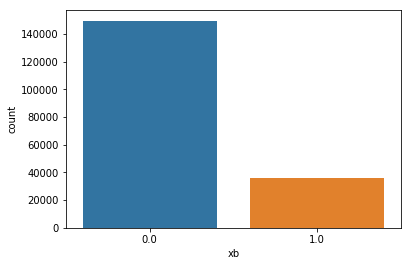

Counter({0.0: 149629, 1.0: 35680})


In [24]:
sns.countplot(member_info['xb'].dropna())
plt.show()
print(Counter(member_info['xb'].dropna()))

#### 3.3 会员年龄分析
* 上图： 会员出生年份的密度估计，可见有很多生日在1753年。可能是系统默认参数，用户登记生日时没有选择更改。
* 下图： 会员出生年份大于1930的密度估计。可见多数用户出生年份在1960-2000。

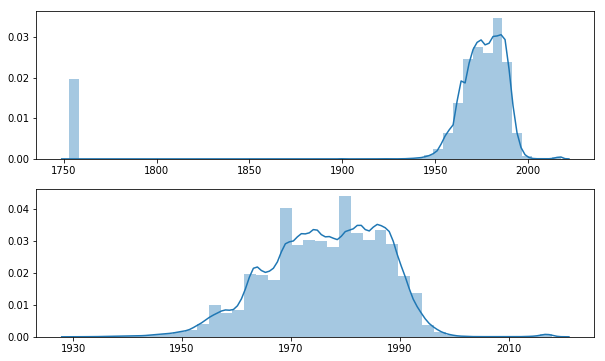

In [46]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
sns.distplot(member_info['csny_year'].dropna().values)

plt.subplot(2,1,2)
sns.distplot(member_info[
    member_info.csny_year > 1930
]['csny_year'].dropna().values, bins =40)
plt.xticks(list(range(1930,2021,20)))

plt.show()

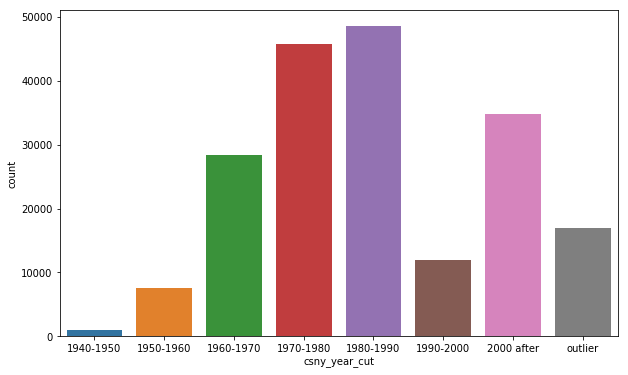

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(x="csny_year_cut", data=member_info,
             order = ['1940-1950', '1950-1960', '1960-1970', '1970-1980',\
                      '1980-1990', '1990-2000', '2000 after', 'outlier'])
plt.show()

#### 3.4 注册时间分析
* 2008-2009年，注册会员数量抖升。
* 多数会员注册时间在2009-2017年。
* 2013年注册会员最多，为25947个。

In [27]:
member_info[member_info.djsj_year > 1930].groupby('djsj_year')['kh'].count()


djsj_year
2002.0       77
2003.0      580
2004.0     1738
2005.0     3803
2006.0     1283
2007.0     1862
2008.0     4807
2009.0    15684
2010.0    14259
2011.0    21507
2012.0    24168
2013.0    25945
2014.0    19137
2015.0    14189
2016.0    13911
2017.0    18945
2018.0      162
Name: kh, dtype: int64

* 每月注册量没有周期性

In [28]:
member_info[member_info.djsj_year > 1930].groupby('djsj_month')['kh'].count()


djsj_month
1.0     16097
2.0     12990
3.0     15043
4.0     14731
5.0     16589
6.0     16099
7.0     13059
8.0     14390
9.0     13416
10.0    15862
11.0    16114
12.0    17667
Name: kh, dtype: int64

### 4. 该店有效会员的消费金额统计。并绘制消费金额分布图。
所用表：附件1-会员信息表；附件3-会员消费明细表

* 用附件1-会员信息表 通过‘kh’键 left merge 附件3-会员消费明细表。得到该店有效会员的消费信息。

In [29]:
our_member_sales = member_info.merge(member_sales,how = 'left',on=['kh']).\
                    dropna(subset=['dtime','spbm','sl','sj','je'])
our_member_sales_buy = our_member_sales[our_member_sales.buy_type=='buy']
print(our_member_sales_buy.shape)
our_member_sales_buy.head(2)


(536292, 19)


,kh,csny,xb,djsj,csny_year,csny_month,djsj_year,djsj_month,csny_year_cut,dtime,spbm,sl,sj,je,spmc,buy_type,dtime_year,dtime_quarter,dtime_month
2,a37cc182,1967-02-17,0.0,2004-12-31,1967.0,2.0,2004.0,12.0,1960-1970,2016-09-25,d62a69e3,1.0,12288.0,11089.93,WMF D无,buy,2016.0,3.0,9.0
3,a37cc182,1967-02-17,0.0,2004-12-31,1967.0,2.0,2004.0,12.0,1960-1970,2016-09-25,d62a69e3,1.0,499.0,297.07,WMF D无,buy,2016.0,3.0,9.0


#### 4.1 该店有效会员的消费金额统计  
用销售金额groupby会员卡号，计算每个会员的购买次数，总/平均/最小/最大购买额。

In [30]:
our_member_sales_buy['je'].describe()

count    5.362920e+05
mean     1.373256e+03
std      3.345126e+03
min      1.000000e-02
25%      3.220000e+02
50%      6.990000e+02
75%      1.575000e+03
max      1.342515e+06
Name: je, dtype: float64

In [31]:
our_member_stastics = our_member_sales_buy.groupby(['kh'], as_index=False)['je'].\
                        agg({"Count":"count",'Sum':'sum', 'Avg':'mean', 'Min':'min', 'Max':'max'})
display(our_member_stastics.head(2))
print(our_member_stastics.shape)
our_member_stastics.to_csv('4_1our_member_stastics.csv')

,kh,Count,Sum,Avg,Min,Max
0,000186fa,18,11880.7,660.038889,148.5,2250.0
1,000234ad,12,12850.0,1070.833333,244.0,2500.0


(48716, 6)


#### 4.2 绘制消费金额分布图
* 会员平均消费金额集中在100-1000

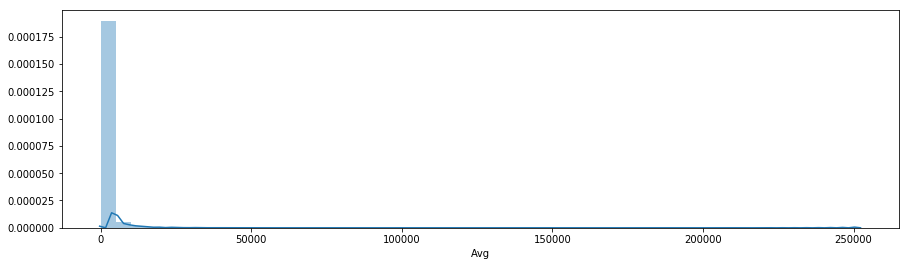

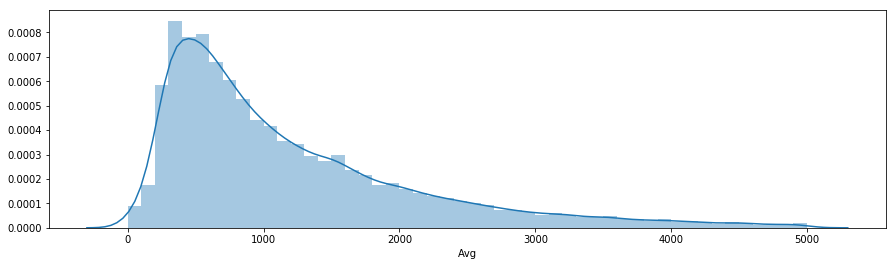

In [32]:
plt.figure(figsize=(15,4))
sns.distplot(our_member_stastics['Avg'])
plt.show()

plt.figure(figsize=(15,4))
sns.distplot(our_member_stastics[
    (our_member_stastics.Avg<5000) & (our_member_stastics.Avg>0)
]['Avg'])
plt.show()

###  5. 通过分析有效会员的性别，年龄，入会时间，消费总额，消费笔数等信息，尝试分析哪些会员才是有价值的会员。给出分析与结果。
所用表：附件1-会员信息表；附件3-会员消费明细表；附件4-商品信息表
* 附件3-会员消费明细表 通过’spbm‘键 left merge 附件4-商品信息表 
* 再通过’kh‘键 left merge 附件1-会员信息表 将三个表聚合在一起

In [33]:
member_sales_commodity = member_sales.merge(commodity_info,how = 'left',on=['spbm']).\
                                      merge(member_info,how = 'left',on=['kh']).\
                                      dropna(subset=['dtime','spbm','sl','je'])
display(member_sales_commodity.head(2))
print(member_sales_commodity.shape)

,kh,dtime,spbm,sl,sj_x,je,spmc_x,buy_type,dtime_year,dtime_quarter,dtime_month,spmc_y,ppbm,lbbm,jxs,xxs,wsjj,hsjj,sj_y,csny,xb,djsj,csny_year,csny_month,djsj_year,djsj_month,csny_year_cut
0,5bfd4a2e,2016-05-08,9096d06f,1,1250.0,1125.0,素然B价件,buy,2016,2,5,素然B价,1066,70101,1.17,1.17,0.0,0.0,0.0,1989-07-05,0.0,2011-05-01,1989.0,7.0,2011.0,5.0,1980-1990
1,0a69471f,2016-05-08,9096d06f,1,1850.0,1665.0,素然B价件,buy,2016,2,5,素然B价,1066,70101,1.17,1.17,0.0,0.0,0.0,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN


(911702, 27)


#### 5.1 通过性别分析
下表可见女性的购买数量和总额明显高于男性。但平均交易额比男性低。

In [34]:
member_sales_commodity.groupby(['xb'], as_index=False)['je'].\
                       agg({'Ave_je':'mean','Count':'count','Sum':'sum'})

,xb,Ave_je,Count,Sum
0,0.0,1307.711421,478734,6.260459e+08
1,1.0,1602.236324,52639,8.434012e+07


#### 5.2 通过出生年份分析
* 下表可见 70后的购买力最强，消费总额最多。其次是60后和80后。

In [35]:
member_sales_commodity.groupby(['csny_year_cut'], as_index=False)['je'].\
                       agg({'Ave_je':'mean','Count':'count','Sum':'sum'}).\
                       sort_values(['Sum'],ascending=False).reset_index(drop = True)


,csny_year_cut,Ave_je,Count,Sum
0,1970-1980,1439.112000,186114,2.678389e+08
1,1960-1970,1564.689552,106980,1.673905e+08
2,1980-1990,1132.568658,133418,1.511050e+08
3,outlier,1187.478368,44521,5.286772e+07
4,2000 after,1294.702797,26406,3.418792e+07
5,1990-2000,978.470043,26738,2.616233e+07
6,1950-1960,1377.460814,16490,2.271433e+07
7,1940-1950,1251.731825,1912,2.393311e+06


#### 5.3 通过登记年份分析
* 下表可见 16年登记的会员的购买力最强，消费总额最多。其次是15年和17年登记的会员。

In [36]:
member_sales_commodity.groupby(['djsj_year'], as_index=False)['je'].\
                       agg({'Ave_je':'mean','Count':'count','Sum':'sum'}).\
                       sort_values(['Sum'],ascending=False).reset_index(drop = True)

,djsj_year,Ave_je,Count,Sum
0,2016.0,1436.295210,107838,1.548872e+08
1,2015.0,1445.349348,88834,1.283962e+08
2,2017.0,1355.995649,80498,1.091549e+08
3,2013.0,1243.827119,45339,5.639388e+07
4,2014.0,1129.736877,38993,4.405183e+07
5,2012.0,1220.361294,35021,4.273827e+07
6,2011.0,1222.211525,33708,4.119831e+07
7,2010.0,1338.991702,26414,3.536813e+07
8,2009.0,1211.240499,23512,2.847869e+07
9,2008.0,1323.808725,9787,1.295612e+07


### 6. 按品牌统计销售额(总体，年度，季度，月度等)及排序
所用表：附件2-销售流水表 附件4-商品信息表   
因为题目没有提及会员，这里用流水表进行计算。

* 附件2-销售流水表 通过‘spbm’键 left merge 附件4-商品信息表

In [37]:
total_sales_commodity =  total_sales.merge(commodity_info,how = 'left',on=['spbm'])
display(total_sales_commodity.head(2))
total_sales_commodity.shape

,spbm,sj_x,sl,je,dtime,dtime_year,dtime_quarter,dtime_month,spmc,ppbm,lbbm,jxs,xxs,wsjj,hsjj,sj_y
0,2811fe0b,180.0,1,180.0,2016-11-06,2016,4,11,罗莱促销F,316,90702,1.17,1.17,0.0,0.0,0.0
1,2811fe0b,1080.0,1,1080.0,2016-11-06,2016,4,11,罗莱促销F,316,90702,1.17,1.17,0.0,0.0,0.0


(1015366, 16)

#### 6.1 总交易额最多的前10个品牌

In [38]:
je_by_ppbm = total_sales_commodity.groupby(['ppbm'], as_index=False)['je'].\
                                    sum().sort_values('je',ascending=False)
je_by_ppbm.head(10)

,ppbm,je
61,531,85268355.96
41,451,59753587.99
72,575,47451479.28
28,343,40079597.53
63,535,35612497.67
107,737,34735128.33
109,753,30967875.89
55,509,26945600.14
261,1148,25465798.07
199,1044,25044554.51


#### 6.2 368个品牌在不同季度的总销售额
有的品牌在某些季度没有销售额则显示NaN   
这里只显示5个  

In [39]:
je_by_ppbm_quarter = total_sales_commodity.groupby(['ppbm','dtime_quarter'], as_index=False)['je'].sum()
je_by_ppbm_quarter_wide = je_by_ppbm_quarter.pivot(index='ppbm',columns='dtime_quarter',values='je')
je_by_ppbm_quarter_wide.shape

(368, 4)

In [40]:
je_by_ppbm_quarter_wide.head(5)

dtime_quarter,1,2,3,4
ppbm,,,,
1,548395.54,498630.24,398685.15,242594.93
2,1162618.96,921459.76,987413.63,492574.15
13,1773161.78,2090012.90,2204529.14,1148266.44
24,280330.20,334014.30,249349.63,167650.44
34,NaN,560.00,NaN,NaN


#### 6.3 368个品牌在不同月的总销售额
这里只显示5个

In [41]:
je_by_ppbm_month = total_sales_commodity.groupby(['ppbm','dtime_month'], as_index=False)['je'].sum()
je_by_ppbm_month_wide = je_by_ppbm_month.pivot(index='ppbm',columns='dtime_month',values='je')
je_by_ppbm_month_wide.shape

(368, 12)

In [42]:
je_by_ppbm_month_wide.head()

dtime_month,1,2,3,4,5,6,7,8,9,10,11,12
ppbm,,,,,,,,,,,,
1,213471.65,144251.28,190672.61,161579.86,194459.08,142591.30,128444.56,165436.94,104803.65,73435.0,85871.82,83288.11
2,427124.09,345445.73,390049.14,305452.95,354261.77,261745.04,270930.72,386869.35,329613.56,172959.0,180669.70,138945.45
13,726071.07,482521.00,564569.71,656526.00,707958.30,725528.60,573923.00,990088.00,640518.14,382994.0,439312.13,325960.31
24,103991.51,78833.84,97504.85,117753.00,117421.50,98839.80,95804.60,65799.00,87746.03,64559.0,71446.44,31645.00
34,NaN,NaN,NaN,560.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7. 分析哪些品牌或类别是受性别，年龄影响较大
所用表同第五问

#### 7.1 哪些品牌受性别影响较大
下表显示了前10个受性别影响最大的品牌。   
及同一品牌，不同性别总销售额差异最大。

In [43]:
ppbm_je0 = member_sales_commodity[
    member_sales_commodity.xb == 0
].groupby(['ppbm'], as_index=False)['je'].mean()

ppbm_je1 = member_sales_commodity[
    member_sales_commodity.xb == 1
].groupby(['ppbm'], as_index=False)['je'].mean()

ppbm_sales_gender = ppbm_je0.merge(ppbm_je1,on = 'ppbm',how = 'inner')
ppbm_sales_gender = ppbm_sales_gender.rename(columns = {'je_x':'female_avg_sales', 'je_y':'male_avg_sales'})
ppbm_sales_gender['difference'] = (ppbm_sales_gender['female_avg_sales'] - ppbm_sales_gender['male_avg_sales']).apply(abs)

display(ppbm_sales_gender.sort_values('difference',ascending = False).reset_index(drop=True).head(10))

,ppbm,female_avg_sales,male_avg_sales,difference
0,763,86000.000000,59825.000000,26175.000000
1,1099,40798.726000,29214.394681,11584.331319
2,1102,4235.313421,12155.000000,7919.686579
3,1016,13389.707692,7353.762712,6035.944980
4,1254,6370.752500,1746.000000,4624.752500
5,1259,9175.910323,13588.980000,4413.069677
6,1270,2751.375314,6987.816667,4236.441353
7,582,5241.618056,1963.454545,3278.163510
8,1089,7842.808173,10763.815000,2921.006827
9,702,3369.236429,6247.520000,2878.283571


#### 7.2 哪些品牌受年龄影响较大

* 计算不同年龄阶段，不同品牌的总销售额。

In [44]:
je_by_ppbm = member_sales_commodity.groupby(['ppbm','csny_year_cut'], as_index=False)['je'].mean()
je_by_ppbm_wide = je_by_ppbm.pivot(index='csny_year_cut',columns='ppbm',values='je')
je_by_ppbm_wide

ppbm,1,2,4,7,10,13,14,16,17,22,24,30,33,34,37,39,45,46,48,49,53,56,67,69,73,74,80,81,83,86,87,90,91,92,93,95,96,98,101,103,104,111,114,116,117,119,123,124,127,130,133,138,143,144,147,150,157,159,161,162,173,176,177,181,182,187,188,190,191,192,193,195,196,208,209,214,215,216,217,220,221,223,227,230,233,234,235,238,243,244,251,255,269,274,278,281,282,283,285,289,292,300,302,304,311,313,316,320,325,327,330,331,334,336,341,342,343,344,345,350,354,355,357,359,361,363,364,368,369,371,372,379,383,386,391,398,401,404,406,407,409,410,417,418,420,421,424,427,430,432,433,435,436,437,438,441,442,447,448,449,450,451,454,455,458,459,460,461,463,465,466,467,469,470,471,473,475,476,478,479,482,483,484,488,489,491,492,494,495,496,497,498,499,501,504,505,508,509,512,515,518,523,529,530,531,532,535,538,541,542,548,549,550,554,556,561,562,567,572,575,576,577,578,579,582,585,592,593,594,595,596,601,602,603,605,606,609,610,617,621,628,632,633,640,646,651,654,659,664,665,...,911,912,913,915,916,919,920,923,927,928,930,931,933,934,936,940,941,942,946,948,949,950,951,956,959,960,961,962,965,966,967,968,976,977,980,984,985,987,988,989,992,993,997,1000,1001,1002,1005,1006,1007,1008,1009,1011,1012,1013,1015,1016,1025,1026,1044,1045,1046,1047,1048,1049,1051,1054,1057,1058,1062,1063,1064,1066,1069,1070,1075,1077,1079,1080,1081,1083,1086,1088,1089,1090,1095,1096,1097,1098,1099,1101,1102,1103,1104,1105,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1161,1162,1163,1164,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1187,1189,1190,1192,1193,1194,1195,1196,1197,1199,1201,1202,1203,1204,1205,1206,1207,1209,1210,1211,1212,1213,1214,1215,1216,1217,1219,1220,1221,1222,1223,1224,1225,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1272,1273,1274,1276,1278
csny_year_cut,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1940-1950,221.250000,274.321915,NaN,NaN,NaN,1583.220000,NaN,NaN,NaN,NaN,738.000000,NaN,NaN,NaN,NaN,1584.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,809.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,718.606667,NaN,NaN,NaN,NaN,NaN,NaN,504.000000,340.416667,NaN,NaN,978.875000,551.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1080.000000,NaN,NaN,290.514000,NaN,NaN,NaN,NaN,278.400000,NaN,NaN,NaN,NaN,NaN,1017.642857,NaN,NaN,NaN,NaN,NaN,3491.218824,NaN,NaN,NaN,3037.925926,1576.600000,NaN,5808.000000,NaN,NaN,NaN,NaN,NaN,NaN,1071.000000,NaN,948.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2148.975000,NaN,NaN,800.000000,NaN,NaN,2100.000000,NaN,NaN,NaN,NaN,168.080882,2509.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1047.273429,NaN,NaN,NaN,NaN,NaN,NaN,373.578148,1363.166667,701.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1696.000000,NaN,NaN,NaN,NaN,2164.500000,NaN,NaN,NaN,203.618788,NaN,NaN,NaN,1162.200000,NaN,NaN,257.666667,NaN,NaN,1190.000000,3135.500000,NaN,2143.746667,NaN,NaN,NaN,1700.000000,277.977500,790.636735,97.500000,1289.666667,NaN,339.469231,NaN,NaN,NaN,724.500000,NaN,2664.600000,NaN,NaN,1291.394737,NaN,1490.000000,1077.800000,NaN,NaN,1324.683333,5580.000000,1388.3857

* 计算不同品牌在不同年龄阶段总销售额的最大值最小值差，挑选出差最大的前10个。

In [45]:
abs(je_by_ppbm_wide.max() - je_by_ppbm_wide.min()).\
        to_frame().sort_values(0,ascending=False).head(10)

,0
ppbm,
763,40450.000000
1099,29483.574345
1007,24751.702500
1259,24489.975000
531,17673.000000
1089,14832.816667
582,14186.285714
1102,14098.400000
1086,13566.666667
